In [1]:
import torch
import torch.nn as nn

from torchvision import transforms

from PIL import Image

In [2]:
# 인코더(Encoder) 정의
classification_vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

# 사전학습된 vgg network와 decoder network의 가중치를 실제 사용할 모델에 로드한다.
classification_vgg.eval()

classification_vgg.load_state_dict(torch.load("../main/pre-trained/vgg_normalised.pth"))

device = torch.device("cuda")
classification_vgg.to(device)

classification_vgg = nn.Sequential(*list(classification_vgg.children())[:31])


for p in classification_vgg.parameters():
    p.requires_grad = False

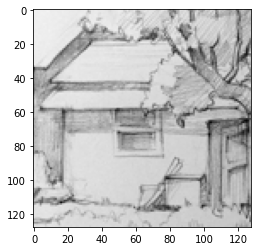

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 전처리 
# 흑백이여야 하지만 color shape은 3shape이여야 함.
image = Image.open("../test_image/content.jpg").convert("L").resize((128, 128))
image = np.repeat(np.array(image), 3).reshape(128, 128, 3)
                  
plt.imshow(image/255.)

In [4]:
image = Image.fromarray(np.uint8(image)).convert("RGB")
image = transforms.Compose([transforms.ToTensor()])(image).to(device).unsqueeze(0)
print(image.size())

torch.Size([1, 3, 128, 128])


In [5]:
print(classification_vgg(image).size())

torch.Size([1, 512, 16, 16])


c:\users\simplepro\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.vgg = classification_vgg
        
        self.fc1 = nn.Linear(512 * 16 * 16, 100, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(100, 30, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
        self.fc3 = nn.Linear(30, 5, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        
        self.relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        out = self.vgg(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.relu(out)
        
        return out

In [7]:
def preprocessing(path):
    
    # 흑백이여야 하지만 color shape은 3shape이여야 함.
    image = Image.open(path).convert("L").resize((128, 128))
    image = np.repeat(np.array(image), 3).reshape(128, 128, 3)
    
    image = Image.fromarray(np.uint8(image)).convert("RGB")
    image = transforms.Compose([transforms.ToTensor()])(image).unsqueeze(0)

    return image

In [11]:
import os

abstract_dir = os.listdir("../dataset/abstract")[:2700]
cityscape_dir = os.listdir("../dataset/cityscape")[:2700]
landscape_dir = os.listdir("../dataset/landscape")[:2700]
portrait_dir = os.listdir("../dataset/portrait")[:2700]
still_life_dir = os.listdir("../dataset/still-life")[:2700]

In [12]:
abstract_y = np.array([0 for i in range(len(abstract_dir))])
cityscape_y = np.array([1 for i in range(len(cityscape_dir))])
landscape_y = np.array([2 for i in range(len(landscape_dir))])
portrait_y = np.array([3 for i in range(len(portrait_dir))])
still_life_y = np.array([4 for i in range(len(still_life_dir))])

In [13]:
Y = np.concatenate((abstract_y, cityscape_y, landscape_y, portrait_y, still_life_y))

print(Y.shape)

(13500,)


In [14]:
X = torch.zeros((13500, 3, 128, 128))

for i in range(len(abstract_dir)):
    X[i] = preprocessing(f"../dataset/abstract/{abstract_dir[i]}")

In [15]:
print(i)

for i in range(len(cityscape_dir)):
    X[2700 + i] = preprocessing(f"../dataset/cityscape/{cityscape_dir[i]}")

2699


In [16]:
for i in range(len(landscape_dir)):
    X[5400+i] = preprocessing(f"../dataset/landscape/{landscape_dir[i]}")

In [17]:
for i in range(len(portrait_dir)):
    X[8100+i] = preprocessing(f"../dataset/portrait/{portrait_dir[i]}")

In [18]:
for i in range(len(still_life_dir)):
    X[10800+i] = preprocessing(f"../dataset/still-life/{still_life_dir[i]}")

In [19]:
print(X.size())

torch.Size([13500, 3, 128, 128])


In [20]:
Y = torch.tensor(Y, dtype=torch.int64)

In [21]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

In [22]:
from torch.optim import Adam

art_classification = Classification().to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer = Adam(art_classification.parameters(), lr=0.002)

total_batch = len(dataloader)
print(total_batch)

225


In [23]:
for epoch in range(10):
    avg_loss = 0
    
    for X, Y in dataloader:
        Y = Y.to(device)
        X = X.to(device)
        
        optimizer.zero_grad()
        pred = art_classification(X)
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
        
    avg_loss /= 15000
    print(f"epoch: {epoch}, avg_loss: {avg_loss}")

epoch: 0, avg_loss: 0.6403685808181763
epoch: 1, avg_loss: 0.0919407457113266
epoch: 2, avg_loss: 0.04601222276687622
epoch: 3, avg_loss: 0.02044730819761753
epoch: 4, avg_loss: 0.012118539772927761
epoch: 5, avg_loss: 0.009979945607483387
epoch: 6, avg_loss: 0.006758708972483873
epoch: 7, avg_loss: 0.009503345936536789
epoch: 8, avg_loss: 0.003335903398692608
epoch: 9, avg_loss: 0.00167023332323879


In [24]:
print("state dict")
for param_tensor in art_classification.state_dict():
    print(f"{param_tensor}: {art_classification.state_dict()[param_tensor].size()}")

state dict
vgg.0.weight: torch.Size([3, 3, 1, 1])
vgg.0.bias: torch.Size([3])
vgg.2.weight: torch.Size([64, 3, 3, 3])
vgg.2.bias: torch.Size([64])
vgg.5.weight: torch.Size([64, 64, 3, 3])
vgg.5.bias: torch.Size([64])
vgg.9.weight: torch.Size([128, 64, 3, 3])
vgg.9.bias: torch.Size([128])
vgg.12.weight: torch.Size([128, 128, 3, 3])
vgg.12.bias: torch.Size([128])
vgg.16.weight: torch.Size([256, 128, 3, 3])
vgg.16.bias: torch.Size([256])
vgg.19.weight: torch.Size([256, 256, 3, 3])
vgg.19.bias: torch.Size([256])
vgg.22.weight: torch.Size([256, 256, 3, 3])
vgg.22.bias: torch.Size([256])
vgg.25.weight: torch.Size([256, 256, 3, 3])
vgg.25.bias: torch.Size([256])
vgg.29.weight: torch.Size([512, 256, 3, 3])
vgg.29.bias: torch.Size([512])
fc1.weight: torch.Size([100, 131072])
fc1.bias: torch.Size([100])
fc2.weight: torch.Size([30, 100])
fc2.bias: torch.Size([30])
fc3.weight: torch.Size([5, 30])
fc3.bias: torch.Size([5])


y label: portrait, 	 predict label: portrait


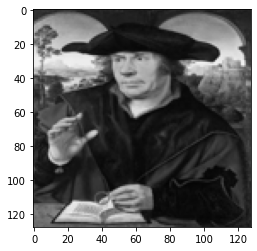

y label: still-life, 	 predict label: still-life


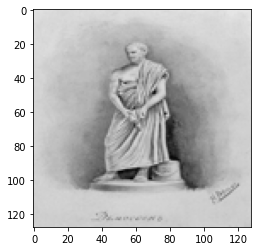

y label: cityscape, 	 predict label: cityscape


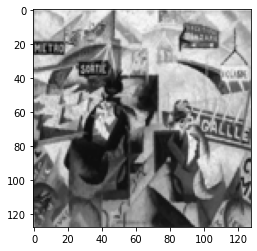

y label: landscape, 	 predict label: landscape


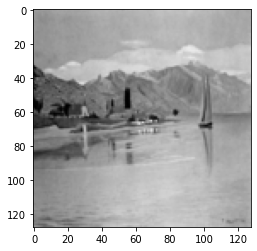

y label: cityscape, 	 predict label: cityscape


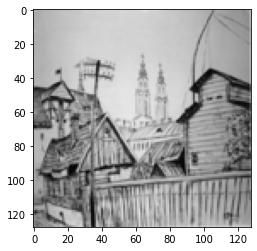

y label: landscape, 	 predict label: landscape


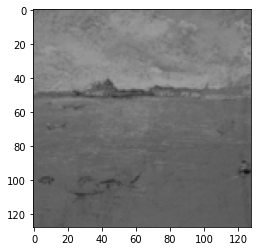

y label: portrait, 	 predict label: portrait


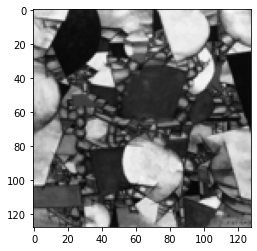

y label: still-life, 	 predict label: still-life


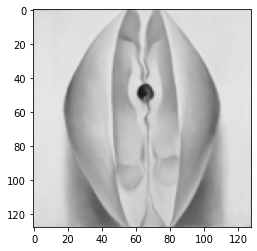

y label: still-life, 	 predict label: still-life


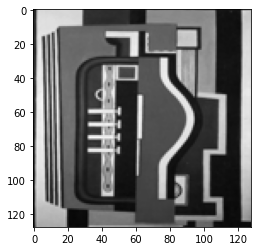

y label: cityscape, 	 predict label: cityscape


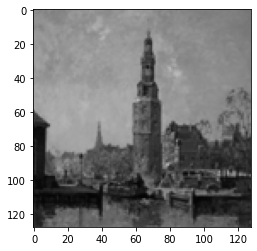

In [25]:
label_dir = {0: "abstract", 1:"cityscape", 2:"landscape", 3:"portrait", 4:"still-life"}

for x, y in zip(X[:10], Y[:10]):
    predict = torch.argmax(art_classification(x.unsqueeze(0))).item()
    print(f"y label: {label_dir[y.item()]}, \t predict label: {label_dir[predict]}")
    plt.imshow(x[0].cpu().detach().numpy().repeat(3).reshape(128, 128, 3))
    plt.show()

In [26]:
torch.save(art_classification.state_dict(), "../main/pre-trained/art_classification.pkl")

In [27]:
model = Classification()
model.load_state_dict(torch.load("../main/pre-trained/art_classification.pkl"))
model.cuda()

Classification(
  (vgg): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): ReflectionPad2d((1, 1, 1, 1))
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (15): ReflectionPad2d((1, 1, 1, 1))
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (17): ReLU()
    (18): ReflectionPad2d((1, 1, 1, 1))
    (19): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (20): ReLU()
    (21):

y label: portrait, 	 predict label: portrait


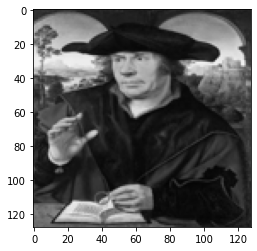

y label: still-life, 	 predict label: still-life


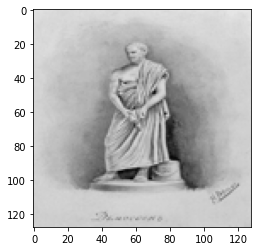

y label: cityscape, 	 predict label: cityscape


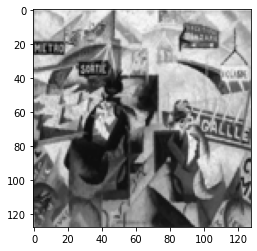

y label: landscape, 	 predict label: landscape


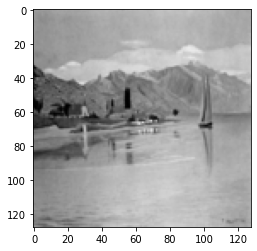

y label: cityscape, 	 predict label: cityscape


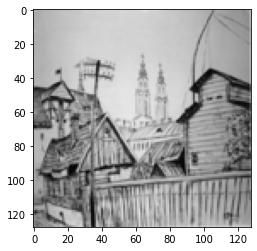

y label: landscape, 	 predict label: landscape


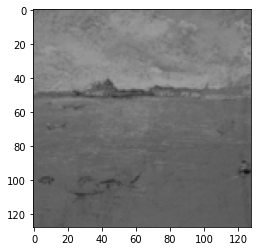

y label: portrait, 	 predict label: portrait


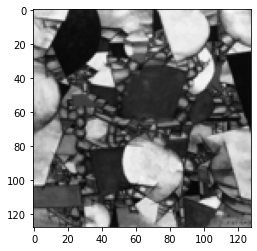

y label: still-life, 	 predict label: still-life


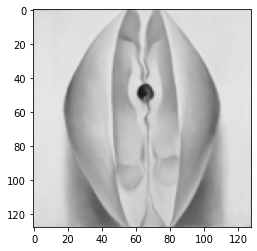

y label: still-life, 	 predict label: still-life


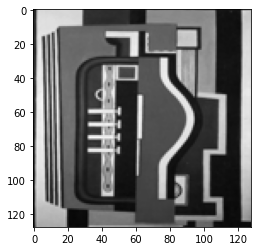

y label: cityscape, 	 predict label: cityscape


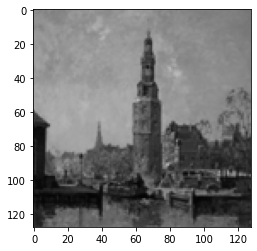

In [28]:
label_dir = {0: "abstract", 1:"cityscape", 2:"landscape", 3:"portrait", 4:"still-life"}

for x, y in zip(X[:10], Y[:10]):
    predict = torch.argmax(model(x.unsqueeze(0))).item()
    print(f"y label: {label_dir[y.item()]}, \t predict label: {label_dir[predict]}")
    plt.imshow(x[0].cpu().detach().numpy().repeat(3).reshape(128, 128, 3))
    plt.show()

In [127]:
abstract_test = os.listdir("../dataset/abstract")[2700:]
cityscape_test = os.listdir("../dataset/cityscape")[2700:]
landscape_test = os.listdir("../dataset/landscape")[2700:]
portrait_test = os.listdir("../dataset/portrait")[2700:]
still_life_test = os.listdir("../dataset/still-life")[2700:]

abstract_y_test = np.array([0 for i in range(len(abstract_test))])
cityscape_y_test = np.array([1 for i in range(len(cityscape_test))])
landscape_y_test = np.array([2 for i in range(len(landscape_test))])
portrait_y_test = np.array([3 for i in range(len(portrait_test))])
still_life_y_test = np.array([4 for i in range(len(still_life_test))])

In [128]:
X = torch.zeros((1500, 3, 128, 128))

for i in range(len(abstract_test)):
    X[i] = preprocessing(f"../dataset/abstract/{abstract_test[i]}")
    
for i in range(len(cityscape_test)):
    X[300+i] = preprocessing(f"../dataset/cityscape/{cityscape_test[i]}")
    
for i in range(len(landscape_test)):
    X[600+i] = preprocessing(f"../dataset/landscape/{landscape_test[i]}")
    
for i in range(len(portrait_test)):
    X[900+i] = preprocessing(f"../dataset/portrait/{portrait_test[i]}")
    
for i in range(len(still_life_test)):
    X[1200+i] = preprocessing(f"../dataset/still-life/{still_life_test[i]}")

In [129]:
acc = 0

for i in range(0, 1500):
    x = X[i]
    x = x.to(device)
    
    predict = model(x.unsqueeze(0))
    predict = predict.cpu().detach()
    
    if torch.argmax(predict) == y_test[i]:
        acc += 1
    
print(acc)

1127
